# SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 !pip install pyreadr

In [3]:
import pandas as pd 
import pyreadr as py 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow as tf 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [4]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU address is grpc://10.44.121.226:8470
Running on TPU  grpc://10.44.121.226:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.44.121.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.121.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER

In [5]:
BASE_SEQ_LEN = 500
NUM_VAR = 52
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

# READ DATA

In [6]:
a1 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Training.RData")
fault_free_training = a1['fault_free_training']
a1 = None 
a2 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Training.RData")
faulty_training = a2['faulty_training']
a2 = None
a3 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Testing.RData")
fault_free_testing = a3['fault_free_testing']
a3 = None 
a4 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Testing.RData")
faulty_testing = a4['faulty_testing']
a4 = None 

In [7]:
gc.collect()

50

In [8]:
for col in fault_free_training.columns: 
    fault_free_training.loc[: , col] = fault_free_training.loc[: , col].astype('float32')

for col in faulty_training.columns: 
    faulty_training.loc[: , col] = faulty_training.loc[: , col].astype('float32')

for col in fault_free_testing.columns: 
    fault_free_testing.loc[: , col] = fault_free_testing.loc[: , col].astype('float32')

for col in faulty_testing.columns: 
    faulty_testing.loc[: , col] = faulty_testing.loc[: , col].astype('float32')


In [10]:
def df_to_np_array(df = fault_free_training): 
    examples = [] 
    for i in df.simulationRun.unique():
        examples.append(df[df.simulationRun == i].iloc[:, 3:].values)
    
    return np.stack(examples)


def get_slice_random_segment(length):
    def slice_random_segment(x):
        start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
        x = x[start:start+length]
        x = tf.reshape(x, (length, NUM_VAR))
        return x 
    return slice_random_segment

def get_split_xy(y_length): 
    def split_xy(x):
        y = x[-y_length:]
        return x[:-y_length], y 
    return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 


def get_detection_xy(df , simrun):

    scaler = preprocessing.StandardScaler()
    scaler.fit(df[df.simulationRun == simrun].iloc[:500, 3:])    
    scaled = scaler.transform(df[df.simulationRun == simrun].iloc[:500, 3:])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
def get_mse(df, simrun, model):

    x, y = get_detection_xy(df, simrun) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()






# MODEL

In [11]:
def get_model():

    with strategy.scope(): 
        model = tf.keras.Sequential([
                                tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                                tfkl.LSTM(64, return_sequences=True), 
                                tfkl.LSTM(64, return_sequences=False),
                                tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                                tfkl.LSTM(64, return_sequences=True),
                                tfkl.Dense(NUM_VAR, activation = 'relu')

        ])

        model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = tfk.losses.MeanSquaredError() )

        model.summary()

    return model 

In [12]:
model = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 64)            29952     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dense (Dense)                (None, 1, 52)             3380      
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________


15/15 [==============================] - 1s 6ms/step


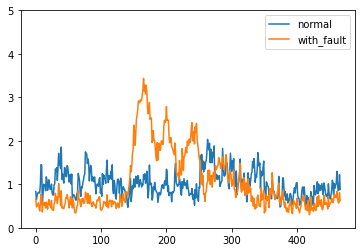

In [13]:
mse_1 = get_mse(fault_free_testing, 1, model)
mse_2 = get_mse(faulty_testing, 1, model)

pd.DataFrame({'normal' : mse_1, 'with_fault' : mse_2}).plot(ylim = (0.0, 5.0))

In [14]:
for train_split, val_split in KFold().split([i+1 for i in range(500)]):
    train_df = fault_free_training[fault_free_training.simulationRun.isin(train_split)]
    val_df = fault_free_training[fault_free_training.simulationRun.isin(val_split)]


    scaler = preprocessing.MinMaxScaler()
    scaler.fit(train_df.iloc[:, 3:].values)

    train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
    val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:].values)

    train_ds = get_dataset(train_df, shuffle = True, repeat=True)
    val_ds = get_dataset(val_df)


    model = get_model() 


    model.fit(
        train_ds, 
        epochs = 20,
        steps_per_epoch = 1000,
        validation_data= val_ds,
        
    )

    break


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32, 64)            29952     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 52)             3380      
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1000/1000 [==============================] - 19s 12ms/step - loss: 0.0925 - val_loss: 0.0824
Epoch 2/20
1